# Gravitational orbits in Cartesian coordinates 

* Make a notebook that solves the two-body problem for gravitational 
attraction between two bodies (e.g., earth and sun) in Cartesian 
coordinates. Implement the differential equation code as a Python class (as 
in our examples). 
* Show that the problem reduces to the orbits considered in class if one of 
the bodies is very heavy and you are in its rest frame. 
* Add Markdown/LaTeX documentation. 
* Use the Leapfrog method to solve the differential equations and show that 
it conserves energy while using the SciPy ODE solvers do not. 
* Extend the simulation to three bodies (i.e., add a planet) in the same plane
and comment on the orbits you find. 
* Add widgets to control the simulation and/or animate the orbits.

* Last revised 29-April-2022 by Yuanhao Shi (shi.1222@osu.edu).

## GravitationalOrbits class and utility functions

In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
class GravitationalOrbits():
    '''
    The GravitationalOrbits class implements the parameters and Lagrange's equations for 
    two particles orbiting under gravitational attraction.
   
    Parameters:
    -----------
    m1 : float, mass of first body 
    m2 : float, mass of second body
    g  : float, gravitational constant
    -----------
    
    Methods: 
    --------
    dy_dt(t, y) 
        Returns the right side of the differential equation in vector y,
        given time, t, and the corresponding value of y.
    --------
    '''
    def __init__(self, m1=1., m2=1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dz_dt(self, t, z):
        '''
        This function returns the right-hand side of the differential equation:
        [dz/dt, d^2z/dt^2]
    
        Parameters: 
        -----------
        t : float, time
        z : float, 8-component vector with z[0] = x1(t), z[1] = x1_dot(t), 
                                           z[2] = y1(t), z[3] = y1_dot(t),
                                           z[4] = x2(t), z[5] = x2_dot(t), 
                                           z[6] = y2(t), z[7] = y2_dot(t).
        -----------
        Returns: 
        '''
        r12 = np.sqrt( (z[0] - z[4])**2. + (z[2] - z[6])**2. )
        
        return [ z[1], self.G * self.m2 * (z[4] - z[0]) / r12**3.,\
                 z[3], self.G * self.m2 * (z[6] - z[2]) / r12**3.,\
                 z[5], -self.G * self.m1 * (z[4] - z[0]) / r12**3.,\
                 z[7], -self.G * self.m1 * (z[6] - z[2]) / r12**3.,\
                ]
    
    def solve_ode(self, t_pts, z_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        '''
        Solves the ODE given initial conditions.
        Specify smaller abserr and selerr to get more presicion.
        '''
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method="RK23",
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_leapfrog(self, t_pts, z_0):
        '''
        Solves the ODE given initial conditions with the Leapfrog method.
        '''
        delta_t = t_pts[1] - t_pts[0]
        
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z_0
    
        # initialize the arrays with zeros
        num = len(t_pts)
        
        x1 = np.zeros(num)
        y1 = np.zeros(num)
        x2 = np.zeros(num)
        y2 = np.zeros(num)
        
        x1_dot = np.zeros(num)
        y1_dot = np.zeros(num)
        x2_dot = np.zeros(num)
        y2_dot = np.zeros(num)
        
        x1_dot_half = np.zeros(num)
        y1_dot_half = np.zeros(num)
        x2_dot_half = np.zeros(num)
        y2_dot_half = np.zeros(num)
        
        # initial conditions
        x1[0] = x1_0
        y1[0] = y1_0
        x2[0] = x2_0
        y2[0] = y2_0
        
        x1_dot[0] = x1_dot_0
        y1_dot[0] = y1_dot_0
        x2_dot[0] = x2_dot_0
        y2_dot[0] = y2_dot_0
        
        # step through differential equations
        for i in np.arange(num - 1):
            t = t_pts[i]
            
            z = [x1[i], x1_dot[i], y1[i], y1_dot[i],\
                 x2[i], x2_dot[i], y2[i], y2_dot[i]]
           
            out = self.dz_dt(t,z)
            
            scat = delta_t / 2.
            
            x1_dot_half[i] = x1_dot[i] + out[1] * scat
            y1_dot_half[i] = y1_dot[i] + out[3] * scat
            x2_dot_half[i] = x2_dot[i] + out[5] * scat
            y2_dot_half[i] = y2_dot[i] + out[7] * scat
            
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            x1_dot[i+1] = x1_dot_half[i] + out[1] * scat
            y1_dot[i+1] = y1_dot_half[i] + out[3] * scat
            x2_dot[i+1] = x2_dot_half[i] + out[5] * scat
            y2_dot[i+1] = y2_dot_half[i] + out[7] * scat
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Make simple orbit plots

In [5]:
# Labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

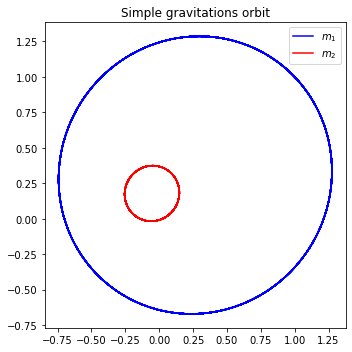

In [6]:
# Initial conditions
G = 1.
m1 = 1.
m2 = 5.

# Instantiate orbit object
o1 = GravitationalOrbits(m1, m2, G)

# Initial conditions with com velovity zero
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1 * x1_0 / m2, -m1 * x1_dot_0 / m2
y2_0, y2_dot_0 = -m1 * x2_0 / m2, -m1 * y1_dot_0 / m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, \
       x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve the initial conditions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = \
         o1.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(5,5)) 
ax = fig.add_subplot(1,1,1)                  

# Set start and stop 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitations orbit')
ax.legend()

fig.tight_layout()
fig.savefig('GravitionalOrbits(1).png', bbox_inches='tight')

Next, I will make plot to show the orbits of two bodies, which one of the bodies is very heavy.

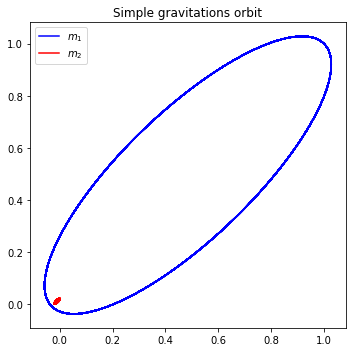

In [7]:
# Common plotting time
t_start = 0.
t_end = 20.
delta_t = 0.00001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# change parameters 
G = 1.
m1 = 1.
m2 = 50.

# Instantiate orbit object
o2 = GravitationalOrbits(m1=m1, m2=m2, G=G)

# Set initial conditions so that CM is initially at rest
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1 * x1_0 / m2, -m1 * x1_dot_0 / m2
y2_0, y2_dot_0 = -m1 * x2_0 / m2, -m1 * y1_dot_0 / m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, \
       x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = \
             o2.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(5,5)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitations orbit')
ax.legend()

fig.tight_layout()
fig.savefig('GravitionalOrbits(2).png', bbox_inches='tight')

Use the Leapfrog method to solve the differential equations.

In [8]:
# Labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 30.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate orbit object
o3 = GravitationalOrbits(m1=m1, m2=m2, G=G)

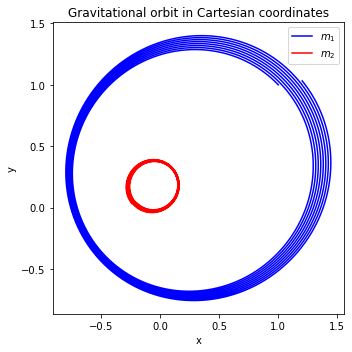

In [9]:
# Set initial conditions 
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1 * x1_0 / m2, -m1 * x1_dot_0 / m2
y2_0, y2_dot_0 = -m1 * x2_0 / m2, -m1 * y1_dot_0 / m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions using Leapfrog method
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o3.solve_ode_leapfrog(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(5,5)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Gravitational orbit in Cartesian coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()
fig.savefig('GravitionalOrbits(3).png', bbox_inches='tight')

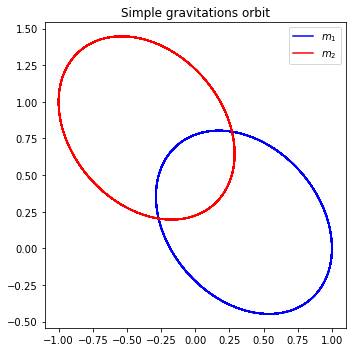

In [10]:
# Common plotting time
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# change parameters 
G = 10.
m1 = 1.
m2 = 1.

# Instantiate orbit object
o4 = GravitationalOrbits(m1=m1, m2=m2, G=G)

# Set initial conditions 
x1_0, x1_dot_0 = 1., 0.
y1_0, y1_dot_0 = 0., 1.
x2_0, x2_dot_0 = -m1 * x1_0 / m2, -m1 * x1_dot_0 / m2
y2_0, y2_dot_0 = -m1 * x2_0 / m2, -m1 * y1_dot_0 / m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, \
       x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = \
             o4.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(5,5)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitations orbit')
ax.legend()

fig.tight_layout()
fig.savefig('GravitionalOrbits(4).png', bbox_inches='tight')

In [11]:
from matplotlib import animation, rc
from IPython.display import HTML

In [12]:
%%capture

x_min = -1.2
x_max = 1.2
y_min = -2
y_max = 2

fig_anim = plt.figure(figsize=(5,3),num="Double pendulum")
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, x_max)

ln1_anim, = ax_anim.plot(x1, y1, color="blue", lw=1)
ln2_anim, = ax_anim.plot(x2, y2, color="red", lw=1)

pt1_anim, = ax_anim.plot(x1[0],y1[0],'o',markersize=8,color='blue')
pt2_anim, = ax_anim.plot(x2[0],y2[0],'o',markersize=8,color='red')

ax_anim.set_aspect(1)
ax_anim.axis("off")
fig_anim.tight_layout()

In [13]:
def animate_orbits(i):
    i_skip = 2 * i
    pt1_anim.set_data(x1[i_skip],y1[i_skip])
    pt2_anim.set_data(x2[i_skip],y2[i_skip])
    return (pt1_anim, pt2_anim)

In [14]:
frame_interval = 10.0
frames_number = 2001
anim = animation.FuncAnimation(fig_anim,
                                animate_orbits,
                                init_func=None,
                                frames=frames_number,
                                interval=frame_interval,
                                blit=True,
                                repeat=False)

In [15]:
HTML(anim.to_jshtml())